# Fitting a double-wilson model to a pair of datasets
## Importing modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy   as np

In [2]:
import reciprocalspaceship as rs
import gemmi
from scipy.optimize  import least_squares, minimize
from scipy.stats     import rice, foldnorm, vonmises, linregress, pearsonr
from dw_tools        import fitting_dw, modify_ds

In [3]:
%autosave 300
# !cat /proc/meminfo | grep Mem
%load_ext autoreload
%autoreload 2
rs.__version__

plt.rcParams.update({'font.size': 14})

Autosaving every 300 seconds


## Loading data

In [4]:
path="double_wilson_data\\" # Windows
# path="double_wilson_data/"    # Unix
# path = "C:\\Users\\Doeke Hekstra\\Documents\\Lab_Hekstra\\Lab_projects\\Hekstra Doeke THz\\LQ92_EGFP_300fs\\"
data_set_pairs = {0:("5kvx_phases", "5kw3_phases"),\
                  1:("5e1y_phases", "2vwr_phases"),\
                  2:("3pyp_phases", "1nwz_phases"),\
                  3:("1otb_phases", "1nwz_phases"),\
                  4:("4eul_phases", "GFP_SSRL_refine_54_final"),\
                  5:("4kjk_phases", "4kjj_phases", "4pst_phases", "4pss_phases"),\
                  6:("e35cdef_OFF200ns_HD_2sig_varEll","e35cdef_200ns_HD_2sig_varEll")}
# data_set_pairs = [("4eul_phases", "GFP_1.37A", "off", "on", "GFP_SSRL_refine_54_final")]
# example 1 fails on kNN regression
example=0
mtz1 = data_set_pairs[example][0] # omit .mtz
mtz2 = data_set_pairs[example][1]
ds1 = rs.read_mtz(path + mtz1 + "_scaled.mtz")
ds2 = rs.read_mtz(path + mtz2 + "_scaled.mtz")

In [5]:
ds1_2 = ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))
ds1_2.label_centrics(inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2, bin_labels = ds1_2.assign_resolution_bins(bins=20, inplace=True, return_labels=True);
# ds1_2.info()

EP1_label = "EP_1_knn_1"
EP2_label = "EP_1_knn_2"
dHKL_label = "dHKL_1"
dHKL_bin_label = "bin"

bin
0    0.009205799
1    0.009064695
2    0.011456031
3    0.015522128
4    0.020852901
5      0.0272395
6    0.034353923
7     0.04245235
8     0.05243219
9    0.066652246
10    0.08257069
11    0.10515357
12    0.13120233
13    0.15628602
14     0.1874515
15    0.21536419
16    0.24899602
17    0.28548962
18    0.32808468
19    0.40595692
Name: SIGEP_1_knn_1, dtype: Stddev


ValueError: values must be a 1D array

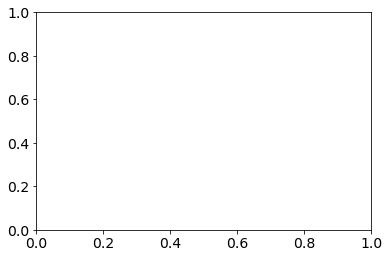

In [7]:
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP1_label].mean()
print(result)
plt.plot(result.to,'bo-', label="<SIG" + EP1_label + ">")
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP2_label].mean()
plt.plot(result,'ro-', label="<SIG" + EP2_label + ">")
plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.ylabel("Avg. SIGEP")
plt.grid(linestyle='--')
plt.ylim([0,plt.ylim()[1]]); plt.legend(); plt.show()

Optionally, apply a resolution cutoff.

In [49]:
if True:
    modify_ds.ds_high_res_cut(ds1_2, rescut=1.1, inplace=True)

In [50]:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],\
                          dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print(a)
print(f"a: {a:.4}")
print(f"b: {b:.4}")

`xtol` termination condition is satisfied.
Function evaluations 15, initial cost 4.4721e+00, final cost 1.2905e-02, first-order optimality 3.08e-06.
0.9429310312010709
a: 0.9429
b: 4.864e-14


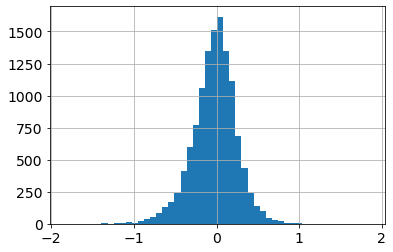

In [51]:
plt.hist(ds1_2[EP1_label]- ds1_2[EP2_label],50)
plt.grid()
plt.show()

## Calculating effective Rice dist parameters per reflection
Consider two data sets of normalized structure factor amplitudes, $\{x\}$ and $\{x+\epsilon+\eta\}$, with the first data set ideal, $\epsilon$ the fixed, true differences between the data sets and $\eta$ the measurement errors. In this case, $\textrm{Cov}(x,x+\epsilon)$ is given by the Double-Wilson distribution, as is $\sigma^2_{x}$. Once we've estimated $a$ and $b$ above such that $r(s)=a\cdot e^{-b s^2}$, we can calculate what value we should use to constrain a prior distribution for another data set by taking into account that our estimates are tainted by measurement error. 

To begin, we'll use the approximate relationship $\rho(|E_1|,|E_2|)=r_{DW}^2$ and the relationship

$\rho^{-2}_{obs}=\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}$,

with $\sigma_x$ the standard deviation of the Wilson distribution and different between centric and acentric reflections. This equation follows from:

$\rho(x,x+\varepsilon+\eta) = \frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}+\sigma^2_{\eta}}}$
and $\rho_{DW}=\rho(x,x+\varepsilon)=\frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}}}$

Now,

$r_{eff}\approx\sqrt{\rho_{obs}}$   and   $\rho_{obs}=1/\sqrt{\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}}$   and   $\rho_{DW}\approx a^2 e^{-2bs^2}$ and $s=1/d_{HKL}$.

In [52]:
 def eff_r_dw_per_hkl(ds, a, b, label, dHKL_label, inplace=True):
    s = ds[dHKL_label].to_numpy()
    r_DW = a * np.exp(-b / (s ** 2))
    rho_DW = r_DW**2
    var_eta = ds["SIG" + label].to_numpy() ** 2
    varW_acentric = rice.var(0, 0, np.sqrt(0.5))
    varW_centric = foldnorm.var(0, 0, 1)
    centric = ds["CENTRIC"] == True
    acentric = ds["CENTRIC"] == False
    rho_obs_ac = 1 / np.sqrt(
        rho_DW ** -2 + var_eta.astype(float) / varW_acentric
    )  # not sure why I had to set the data type explicitly; otherwise just "object"
    rho_obs_c = 1 / np.sqrt(rho_DW ** -2 + var_eta.astype(float) / varW_centric)

In [53]:
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP1_label, dHKL_label=dHKL_label, inplace=True);
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP2_label, dHKL_label=dHKL_label, inplace=True);

In [56]:
# ds1_2.info()
ds1_2.to_pickle(path + "_LQ92_OFF_1_SSRL_2_all_sg19_w_rDW.pkl")

# _1 = LCLS_OFF; _2 = SSRL_OFF _all_19

In [57]:
import pandas as pd
test = pd.read_pickle(path + "_LQ92_OFF_1_SSRL_2_all_sg19_w_rDW.pkl")
test.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 12283 entries, (0, 0, 4) to (26, 13, 1)
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype                
---  ------               --------------  -----                
 0   F                    12283 non-null  SFAmplitude          
 1   SigF                 12283 non-null  Stddev               
 2   I                    12283 non-null  Intensity            
 3   SigI                 12283 non-null  Stddev               
 4   FP_1                 12283 non-null  SFAmplitude          
 5   SIGFP_1              12283 non-null  Stddev               
 6   rs_a_1               12283 non-null  MTZReal              
 7   rs_b_1               12283 non-null  MTZReal              
 8   rs_c_1               12283 non-null  MTZReal              
 9   dHKL_1               12283 non-null  MTZReal              
 10  CENTRIC_1            12283 non-null  bool                 
 11  EPSILON_1            12283 non-n

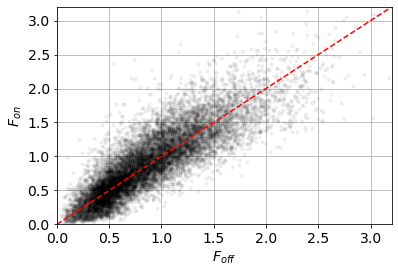

In [37]:
plt.plot(ds1_2[EP1_label],ds1_2[EP2_label],'k.',alpha=0.05)
xl=np.array(plt.xlim())
plt.plot(xl,xl,'r--')
plt.grid(); plt.xlim((0,3.2)); plt.ylim((0,3.2))
plt.xlabel(r'$F_{off}$')
plt.ylabel(r'$F_{on}$')
plt.show()

**~ ~ At this point, we're really done. ~ ~**

What follows is additional some inspection.

## Binning by $|E_1|$
Means per bin for $|E_1|$, determined separately for acentrics and centrics.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. We'll set bin labels for both centrics and acentrics here:

In [14]:
nbin=25
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2_centric  = (ds1_2["CENTRIC"].to_numpy()==True)
ds1_2_acentric = (ds1_2["CENTRIC"].to_numpy()==False)

ep1_bins          = np.percentile(ds1_2.loc[ds1_2_acentric, EP1_label], cdf_bins)
ep1_bins[-1]      = ep1_bins[-1]+1e-6                # to avoid omitting the largest data point
ep1_dig           = np.digitize(ds1_2.loc[  ds1_2_acentric, EP1_label], ep1_bins) # note that we're creating bin labels for all reflections, acentric or not

ep1_cent_bins     = np.percentile(ds1_2.loc[ds1_2_centric,  EP1_label], cdf_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6
ep1_cent_dig      = np.digitize(ds1_2.loc[  ds1_2_centric,  EP1_label], ep1_cent_bins) # note that we're creating bin labels for all reflections, acentric or not

ds1_2.loc[ds1_2_acentric, "EP_1_bin"] = ep1_dig.flatten()
ds1_2.loc[ds1_2_centric,  "EP_1_bin"] = ep1_cent_dig.flatten()

Some inspection of the created bins!

Number of reflections per bin (acentric):
{1.0: 1089, 2.0: 1088, 3.0: 1088, 4.0: 1088, 5.0: 1088, 6.0: 1088, 7.0: 1088, 8.0: 1088, 9.0: 1088, 10.0: 1088, 11.0: 1088, 12.0: 1088, 13.0: 1088, 14.0: 1088, 15.0: 1088, 16.0: 1088, 17.0: 1088, 18.0: 1088, 19.0: 1088, 20.0: 1088, 21.0: 1088, 22.0: 1088, 23.0: 1088, 24.0: 1088, 25.0: 1089}

Number of reflections per bin (centric):
{1.0: 124, 2.0: 124, 3.0: 123, 4.0: 124, 5.0: 124, 6.0: 123, 7.0: 124, 8.0: 124, 9.0: 123, 10.0: 124, 11.0: 124, 12.0: 123, 13.0: 124, 14.0: 123, 15.0: 124, 16.0: 124, 17.0: 123, 18.0: 124, 19.0: 124, 20.0: 123, 21.0: 124, 22.0: 124, 23.0: 123, 24.0: 124, 25.0: 124}


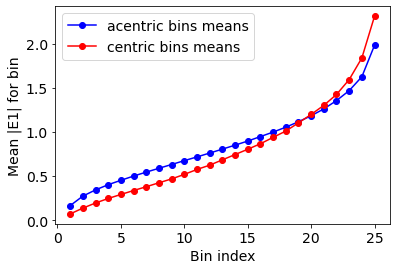

In [15]:
# For acentrics:
unique, counts = np.unique(ds1_2.loc[ds1_2_acentric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):"); print(temp)
print()

# for centrics
unique, counts = np.unique(ds1_2.loc[ds1_2_centric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (centric):");  print(temp)

bin_means_acentric = ds1_2[ds1_2_acentric].groupby("EP_1_bin")[EP1_label].mean()
bin_means_centric  = ds1_2[ds1_2_centric ].groupby("EP_1_bin")[EP1_label].mean()
plt.plot(bin_means_acentric,'bo-',label="acentric bins means")
plt.plot(bin_means_centric, 'ro-',label="centric bins means")
plt.xlabel("Bin index"); plt.ylabel("Mean |E1| for bin")
plt.legend(); plt.show()

## Conditional distribution for Acentrics. Histograms of $|E_2|$ per bin of $|E_1|$.
**Note**: this does not yet use the $a$ and $b$ estimated above.

<ipython-input-18-45d763631e57>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,5,3)


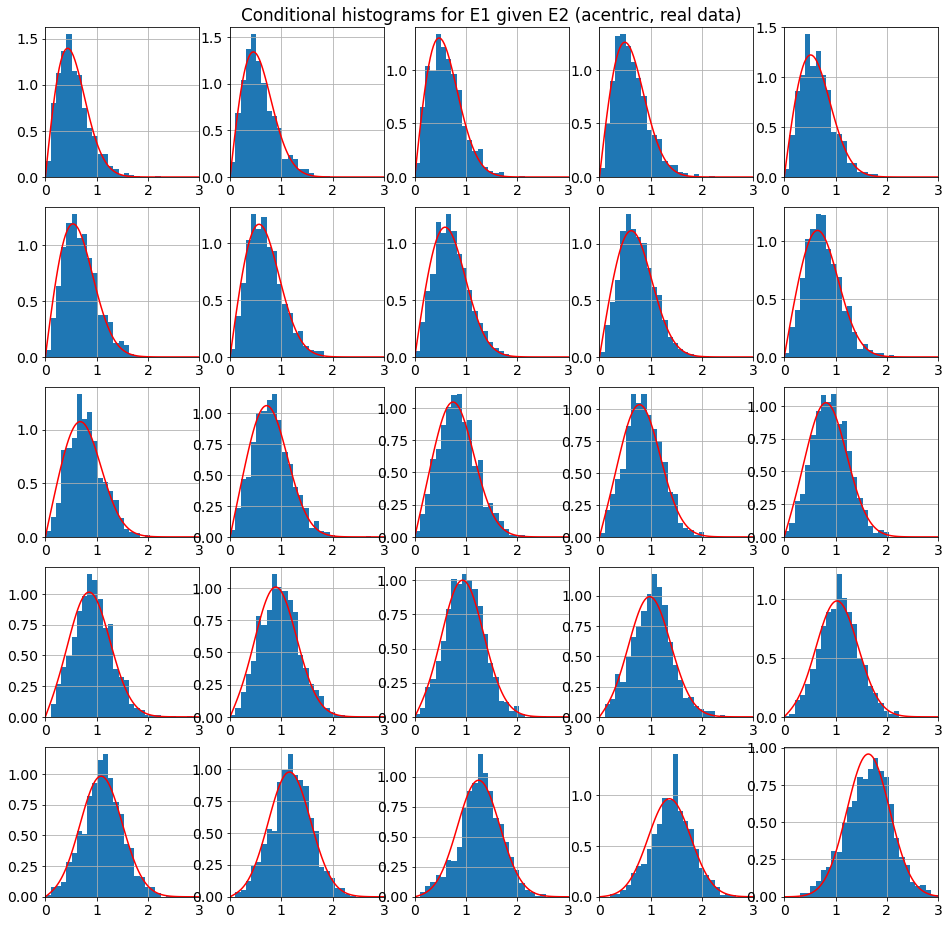

In [18]:
plt.figure(figsize=(16,16))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.8                        # a guess of the corr coef between data sets
    r1  = rho*bin_means_acentric[i]  # conditional exp value of E1 given E2
    cond_var = 0.5*(1-rho**2)        # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric, EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl); plt.grid()

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (acentric, real data)")
plt.show()

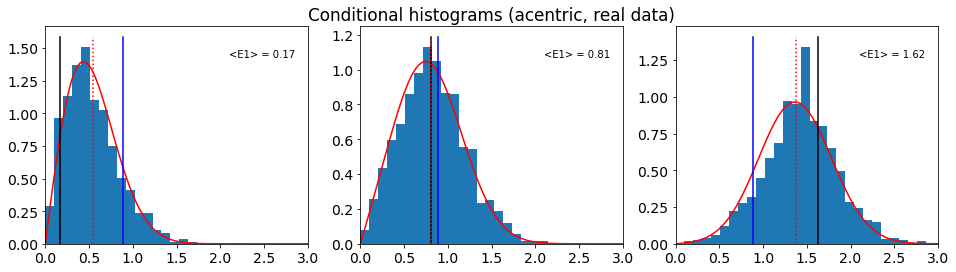

In [19]:
plt.figure(figsize=(16,4))
x=np.linspace(0,3,100)
counter = 0
for i in [1, 13, 24]:
    counter += 1             # for illustration purposes.
    plt.subplot(1,3,counter) # for illustration purposes.
    r_DW = 0.8
    r1 = r_DW*bin_means_acentric[i]     # conditional exp value
    cond_var = 0.5*(1-r_DW**2) # conditional var for acentrics
    
    plt.hist(ds1_2.loc[ds1_2["EP_1_bin"]==i,EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()

#    to illustrate the idea of Rice interpolating between Wilson and delta function:
    plt.plot(bin_means_acentric[i]*np.asarray([1, 1]),yl,'k-')
    plt.plot(rice.mean(0,scale=1/np.sqrt(2))*np.asarray([1,1]),yl,'b-')
    plt.plot(rice.mean(r1/np.sqrt(cond_var),scale=np.sqrt(cond_var))*np.asarray([1,1]),yl,'r:')
    xl=[0,3] #plt.xlim()
    plt.text(2.1,0.9*yl[1],f"<E1> = {bin_means_acentric[i]:.2f}",size=10)
    plt.xlim(xl)
    if counter == 2:
        plt.title("Conditional histograms (acentric, real data)")
 
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

## Conditional distribution for Centrics. Histograms of $|E_2|$ per bin of $|E_1|$.

<ipython-input-20-20baa339114a>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,5,3)


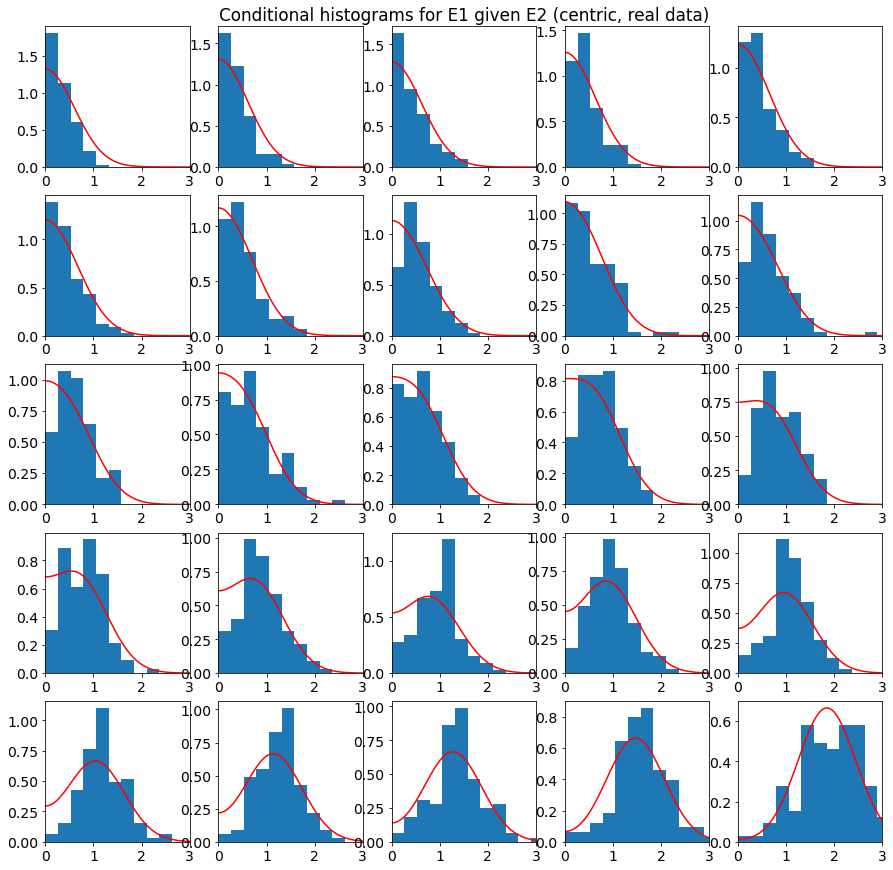

In [20]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.8                       # a guess of the corr coef between data sets
    r1  = rho*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-rho**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_centric,EP2_label],np.linspace(0,5,20),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.show()

## Let's take a look at phases!
Ultimately, this work should set us up to create full conditional distributions of one dataset given another, and to propagate these ideas to refinement.

In [21]:
# ALl "phase keys":
ds1_2.filter(regex="PH").info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 30294 entries, (0, 0, 4) to (24, 5, 13)
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   PHIC_1         30294 non-null  Phase
 1   PHIC_ALL_1     30294 non-null  Phase
 2   PHWT_1         30294 non-null  Phase
 3   PHDELWT_1      30294 non-null  Phase
 4   PHIC_ALL_LS_1  30294 non-null  Phase
 5   PHIC_2         30294 non-null  Phase
 6   PHIC_ALL_2     30294 non-null  Phase
 7   PHWT_2         30294 non-null  Phase
 8   PHDELWT_2      30294 non-null  Phase
 9   PHIC_ALL_LS_2  30294 non-null  Phase
dtypes: Phase(10)
memory usage: 2.4 MB


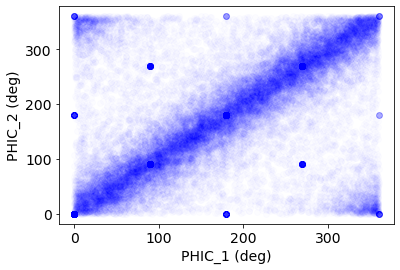

In [22]:
plt.plot(ds1_2["PHIC_1"].to_numpy(),ds1_2["PHIC_2"].to_numpy(),'bo',alpha=0.01)
plt.xlabel("PHIC_1 (deg)")
plt.ylabel("PHIC_2 (deg)")
plt.show()

not sure what the differences are, but they're all close!

Because of the structure of the Von Mises distribution, the conditional probability of the phase difference of E1 and E2 is a function only of E1 x E2. We'll bin by that. For now, we'll only think about acentrics.

Specifically, the Von Mises distribution (Bricogne, Methods in Enzymology, eq. 1.10) is given by:

$P\left( \varphi | R, r \right) = \frac{1}{2\pi I_0(z)}\exp\left( z \cos(\Delta \varphi)\right)$ 

with $z = \frac{2 r R}{(1-\rho^2)}$

which can also be derived by dividing eq. 14 for $P(R,\varphi | r)$ by eq. 15 for $P(R | r)$ in my current notes. The mapping between the notation of Bricogne and ours is a little awkward. Specifically, $\rho=r_{DW}$, $R=|E2|$ and $r=|E1|$.

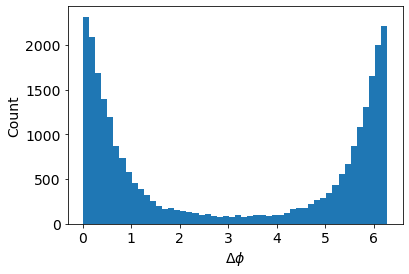

In [23]:
ds1_2["DeltaPHIC"] = np.remainder((np.pi/180.0)*(ds1_2["PHIC_2"].to_numpy()-ds1_2["PHIC_1"].to_numpy()),2*np.pi)
ds1_2["cos(DeltaPHIC)"] = np.cos(ds1_2["DeltaPHIC"])

plt.hist(ds1_2.loc[ds1_2["CENTRIC"]==False, "DeltaPHIC"],50 )
plt.xlabel(r"$\Delta\phi$")
plt.ylabel('Count')
plt.show()

In [24]:
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2["EP1_EP2"]  = ds1_2[EP1_label] * ds1_2[EP2_label]                                 

# For acentrics:
ep12_bins       = np.percentile(ds1_2.loc[ds1_2_acentric, "EP1_EP2"], cdf_bins)
ep12_bins[-1]   = ep12_bins[-1]+1e-6                # to avoid omitting the largest data point
ep12_dig        = np.digitize(ds1_2.loc[  ds1_2_acentric, "EP1_EP2"], ep12_bins)
ds1_2.loc[ds1_2_acentric, "EP1_EP2_bin"] = ep12_dig.flatten()

unique, counts = np.unique(ds1_2.loc[ds1_2_acentric, "EP1_EP2_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)

bin_means_12_acentric = ds1_2[ds1_2_acentric].groupby("EP1_EP2_bin")["EP1_EP2"].mean()                                 

Number of reflections per bin (acentric):
{1.0: 1089, 2.0: 1088, 3.0: 1088, 4.0: 1088, 5.0: 1088, 6.0: 1088, 7.0: 1088, 8.0: 1088, 9.0: 1088, 10.0: 1088, 11.0: 1088, 12.0: 1088, 13.0: 1088, 14.0: 1088, 15.0: 1088, 16.0: 1088, 17.0: 1088, 18.0: 1088, 19.0: 1088, 20.0: 1088, 21.0: 1088, 22.0: 1088, 23.0: 1088, 24.0: 1088, 25.0: 1089}


We again simplify to a single correlation coefficient over the resolution range.

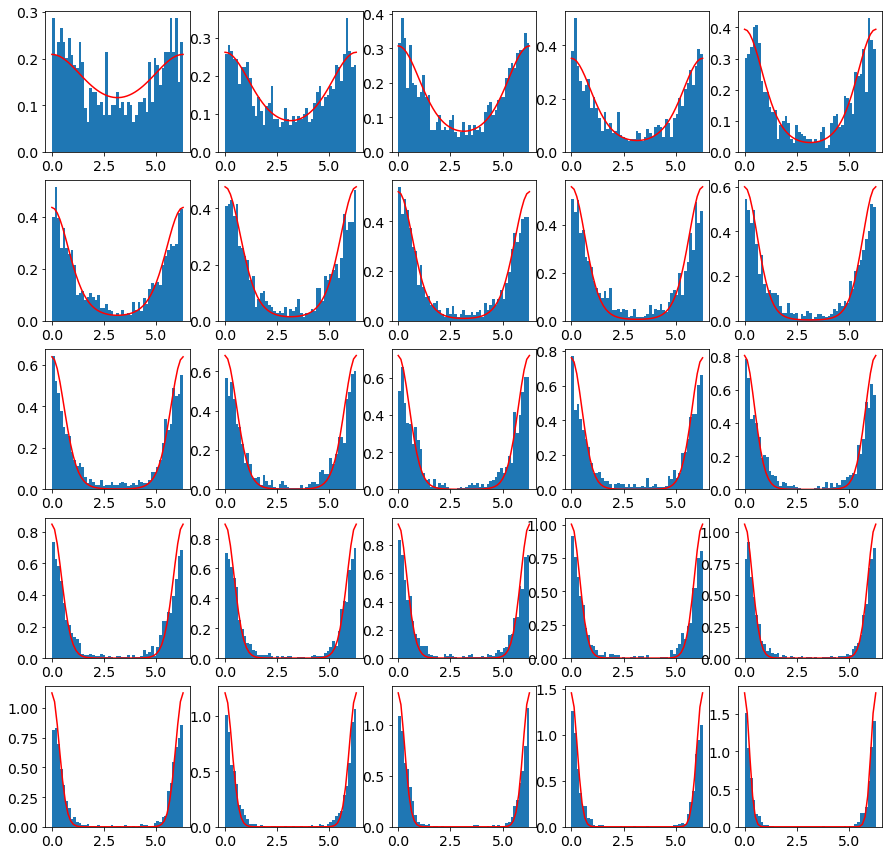

In [25]:
# for acentrics:
plt.figure(figsize=(15,15))
x = np.linspace(0,2*np.pi,50)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.8                          # a guess of the corr coef between data sets
    cond_var = 0.5*(1-rho**2)          # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric, "DeltaPHIC"],np.linspace(0,2*np.pi,50),density=True)
    plt.plot(x, vonmises.pdf(x, bin_means_12_acentric[i]/cond_var),'r-')

plt.show()